In [1]:
%matplotlib inline


# Transformations Tutorial


Like any graphics packages, Matplotlib is built on top of a
transformation framework to easily move between coordinate systems,
the userland `data` coordinate system, the `axes` coordinate system,
the `figure` coordinate system, and the `display` coordinate system.
In 95% of your plotting, you won't need to think about this, as it
happens under the hood, but as you push the limits of custom figure
generation, it helps to have an understanding of these objects so you
can reuse the existing transformations Matplotlib makes available to
you, or create your own (see :mod:`matplotlib.transforms`).  The table
below summarizes the some useful coordinate systems, the transformation
object you should use to work in that coordinate system, and the
description of that system. In the `Transformation Object` column,
``ax`` is a :class:`~matplotlib.axes.Axes` instance, and ``fig`` is a
:class:`~matplotlib.figure.Figure` instance.

+----------------+-----------------------------+-----------------------------------+
|Coordinates     |Transformation object        |Description                        |
+================+=============================+===================================+
|"data"          |``ax.transData``             |The coordinate system for the data,|
|                |                             |controlled by xlim and ylim.       |
+----------------+-----------------------------+-----------------------------------+
|"axes"          |``ax.transAxes``             |The coordinate system of the       |
|                |                             |`~matplotlib.axes.Axes`; (0, 0)    |
|                |                             |is bottom left of the axes, and    |
|                |                             |(1, 1) is top right of the axes.   |
+----------------+-----------------------------+-----------------------------------+
|"figure"        |``fig.transFigure``          |The coordinate system of the       |
|                |                             |`.Figure`; (0, 0) is bottom left   |
|                |                             |of the figure, and (1, 1) is top   |
|                |                             |right of the figure.               |
+----------------+-----------------------------+-----------------------------------+
|"figure-inches" |``fig.dpi_scale_trans``      |The coordinate system of the       |
|                |                             |`.Figure` in inches; (0, 0) is     |
|                |                             |bottom left of the figure, and     |
|                |                             |(width, height) is the top right   |
|                |                             |of the figure in inches.           |
+----------------+-----------------------------+-----------------------------------+
|"display"       |``None``, or                 |The pixel coordinate system of the |
|                |``IdentityTransform()``      |display window; (0, 0) is bottom   |
|                |                             |left of the window, and (width,    |
|                |                             |height) is top right of the        |
|                |                             |display window in pixels.          |
+----------------+-----------------------------+-----------------------------------+
|"xaxis",        |``ax.get_xaxis_transform()``,|Blended coordinate systems; use    |
|"yaxis"         |``ax.get_yaxis_transform()`` |data coordinates on one of the axis|
|                |                             |and axes coordinates on the other. |
+----------------+-----------------------------+-----------------------------------+

All of the transformation objects in the table above take inputs in
their coordinate system, and transform the input to the ``display``
coordinate system.  That is why the ``display`` coordinate system has
``None`` for the ``Transformation Object`` column -- it already is in
display coordinates.  The transformations also know how to invert
themselves, to go from ``display`` back to the native coordinate system.
This is particularly useful when processing events from the user
interface, which typically occur in display space, and you want to
know where the mouse click or key-press occurred in your data
coordinate system.

Note that specifying objects in ``display`` coordinates will change their
location if the ``dpi`` of the figure changes.  This can cause confusion when
printing or changing screen resolution, because the object can change location
and size.  Therefore it is most common
for artists placed in an axes or figure to have their transform set to
something *other* than the `~.transforms.IdentityTransform()`; the default when
an artist is placed on an axes using `~.Axes.axes.add_artist` is for the
transform to be ``ax.transData``.


Data coordinates
================

Let's start with the most commonly used coordinate, the `data`
coordinate system.  Whenever you add data to the axes, Matplotlib
updates the datalimits, most commonly updated with the
:meth:`~matplotlib.axes.Axes.set_xlim` and
:meth:`~matplotlib.axes.Axes.set_ylim` methods.  For example, in the
figure below, the data limits stretch from 0 to 10 on the x-axis, and
-1 to 1 on the y-axis.


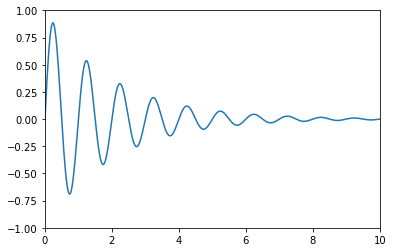

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

plt.show()

You can use the ``ax.transData`` instance to transform from your
`data` to your `display` coordinate system, either a single point or a
sequence of points as shown below:

.. sourcecode:: ipython

    In [14]: type(ax.transData)
    Out[14]: <class 'matplotlib.transforms.CompositeGenericTransform'>

    In [15]: ax.transData.transform((5, 0))
    Out[15]: array([ 335.175,  247.   ])

    In [16]: ax.transData.transform([(5, 0), (1, 2)])
    Out[16]:
    array([[ 335.175,  247.   ],
           [ 132.435,  642.2  ]])

You can use the :meth:`~matplotlib.transforms.Transform.inverted`
method to create a transform which will take you from display to data
coordinates:

.. sourcecode:: ipython

    In [41]: inv = ax.transData.inverted()

    In [42]: type(inv)
    Out[42]: <class 'matplotlib.transforms.CompositeGenericTransform'>

    In [43]: inv.transform((335.175,  247.))
    Out[43]: array([ 5.,  0.])

If your are typing along with this tutorial, the exact values of the
display coordinates may differ if you have a different window size or
dpi setting.  Likewise, in the figure below, the display labeled
points are probably not the same as in the ipython session because the
documentation figure size defaults are different.



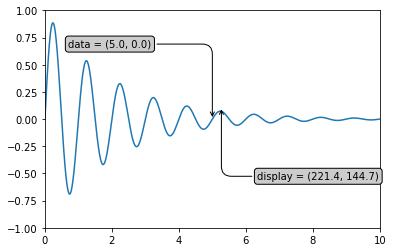

In [3]:
x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
xdisplay, ydisplay = ax.transData.transform_point((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate('data = (%.1f, %.1f)' % (xdata, ydata),
            (xdata, ydata), xytext=(-2*offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

disp = ax.annotate('display = (%.1f, %.1f)' % (xdisplay, ydisplay),
                   (xdisplay, ydisplay), xytext=(0.5*offset, -offset),
                   xycoords='figure pixels',
                   textcoords='offset points',
                   bbox=bbox, arrowprops=arrowprops)

plt.show()

<div class="alert alert-info"><h4>Note</h4><p>If you run the source code in the example above in a GUI backend,
  you may also find that the two arrows for the `data` and `display`
  annotations do not point to exactly the same point.  This is because
  the display point was computed before the figure was displayed, and
  the GUI backend may slightly resize the figure when it is created.
  The effect is more pronounced if you resize the figure yourself.
  This is one good reason why you rarely want to work in display
  space, but you can connect to the ``'on_draw'``
  :class:`~matplotlib.backend_bases.Event` to update figure
  coordinates on figure draws; see `event-handling-tutorial`.</p></div>

When you change the x or y limits of your axes, the data limits are
updated so the transformation yields a new display point.  Note that
when we just change the ylim, only the y-display coordinate is
altered, and when we change the xlim too, both are altered.  More on
this later when we talk about the
:class:`~matplotlib.transforms.Bbox`.

.. sourcecode:: ipython

    In [54]: ax.transData.transform((5, 0))
    Out[54]: array([ 335.175,  247.   ])

    In [55]: ax.set_ylim(-1, 2)
    Out[55]: (-1, 2)

    In [56]: ax.transData.transform((5, 0))
    Out[56]: array([ 335.175     ,  181.13333333])

    In [57]: ax.set_xlim(10, 20)
    Out[57]: (10, 20)

    In [58]: ax.transData.transform((5, 0))
    Out[58]: array([-171.675     ,  181.13333333])



Axes coordinates
================

After the `data` coordinate system, `axes` is probably the second most
useful coordinate system.  Here the point (0, 0) is the bottom left of
your axes or subplot, (0.5, 0.5) is the center, and (1.0, 1.0) is the
top right.  You can also refer to points outside the range, so (-0.1,
1.1) is to the left and above your axes.  This coordinate system is
extremely useful when placing text in your axes, because you often
want a text bubble in a fixed, location, e.g., the upper left of the axes
pane, and have that location remain fixed when you pan or zoom.  Here
is a simple example that creates four panels and labels them 'A', 'B',
'C', 'D' as you often see in journals.



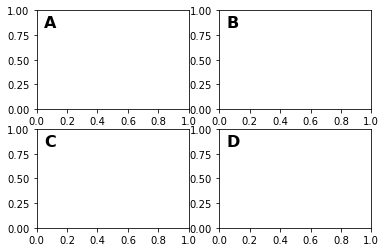

In [4]:
fig = plt.figure()
for i, label in enumerate(('A', 'B', 'C', 'D')):
    ax = fig.add_subplot(2, 2, i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.show()

You can also make lines or patches in the axes coordinate system, but
this is less useful in my experience than using ``ax.transAxes`` for
placing text.  Nonetheless, here is a silly example which plots some
random dots in `data` space, and overlays a semi-transparent
:class:`~matplotlib.patches.Circle` centered in the middle of the axes
with a radius one quarter of the axes -- if your axes does not
preserve aspect ratio (see :meth:`~matplotlib.axes.Axes.set_aspect`),
this will look like an ellipse.  Use the pan/zoom tool to move around,
or manually change the data xlim and ylim, and you will see the data
move, but the circle will remain fixed because it is not in `data`
coordinates and will always remain at the center of the axes.



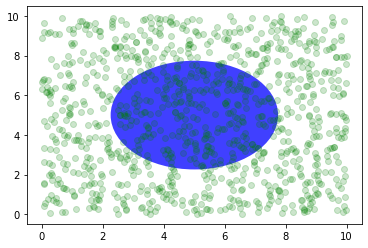

In [5]:
fig, ax = plt.subplots()
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y, 'go', alpha=0.2)  # plot some data in data coordinates

circ = mpatches.Circle((0.5, 0.5), 0.25, transform=ax.transAxes,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()


Blended transformations
=======================

Drawing in `blended` coordinate spaces which mix `axes` with `data`
coordinates is extremely useful, for example to create a horizontal
span which highlights some region of the y-data but spans across the
x-axis regardless of the data limits, pan or zoom level, etc.  In fact
these blended lines and spans are so useful, we have built in
functions to make them easy to plot (see
:meth:`~matplotlib.axes.Axes.axhline`,
:meth:`~matplotlib.axes.Axes.axvline`,
:meth:`~matplotlib.axes.Axes.axhspan`,
:meth:`~matplotlib.axes.Axes.axvspan`) but for didactic purposes we
will implement the horizontal span here using a blended
transformation.  This trick only works for separable transformations,
like you see in normal Cartesian coordinate systems, but not on
inseparable transformations like the
:class:`~matplotlib.projections.polar.PolarAxes.PolarTransform`.



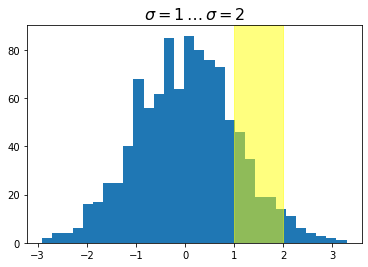

In [6]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots()
x = np.random.randn(1000)

ax.hist(x, 30)
ax.set_title(r'$\sigma=1 \/ \dots \/ \sigma=2$', fontsize=16)

# the x coords of this transformation are data, and the
# y coord are axes
trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

# highlight the 1..2 stddev region with a span.
# We want x to be in data coordinates and y to
# span from 0..1 in axes coords
rect = mpatches.Rectangle((1, 0), width=1, height=1,
                         transform=trans, color='yellow',
                         alpha=0.5)

ax.add_patch(rect)

plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The blended transformations where x is in data coords and y in axes
  coordinates is so useful that we have helper methods to return the
  versions mpl uses internally for drawing ticks, ticklabels, etc.
  The methods are :meth:`matplotlib.axes.Axes.get_xaxis_transform` and
  :meth:`matplotlib.axes.Axes.get_yaxis_transform`.  So in the example
  above, the call to
  :meth:`~matplotlib.transforms.blended_transform_factory` can be
  replaced by ``get_xaxis_transform``::

    trans = ax.get_xaxis_transform()</p></div>


Plotting in physical units
==========================

Sometimes we want an object to be a certain physical size on the plot.
Here we draw the same circle as above, but in physical units.  If done
interactively, you can see that changing the size of the figure does
not change the offset of the circle from the lower-left corner,
does not change its size, and the circle remains a circle regardless of
the aspect ratio of the axes.



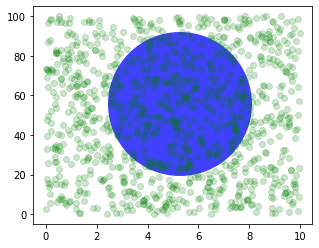

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y*10., 'go', alpha=0.2)  # plot some data in data coordinates
# add a circle in fixed-units
circ = mpatches.Circle((2.5, 2), 1.0, transform=fig.dpi_scale_trans,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()

If we change the figure size, the circle does not change its absolute
position and is cropped.



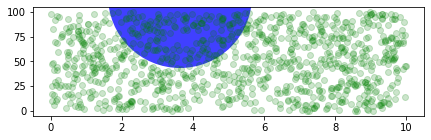

In [8]:
fig, ax = plt.subplots(figsize=(7, 2))
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y*10., 'go', alpha=0.2)  # plot some data in data coordinates
# add a circle in fixed-units
circ = mpatches.Circle((2.5, 2), 1.0, transform=fig.dpi_scale_trans,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()

Another use is putting a patch with a set physical dimension around a
data point on the axes.  Here we add together two transforms.  The
first sets the scaling of how large the ellipse should be and the second
sets its position.  The ellipse is then placed at the origin, and then
we use the helper transform :class:`~matplotlib.transforms.ScaledTranslation`
to move it
to the right place in the ``ax.transData`` coordinate system.
This helper is instantiated with::

  trans = ScaledTranslation(xt, yt, scale_trans)

where `xt` and `yt` are the translation offsets, and `scale_trans` is
a transformation which scales `xt` and `yt` at transformation time
before applying the offsets.

Note the use of the plus operator on the transforms below.
This code says: first apply the scale transformation ``fig.dpi_scale_trans``
to make the ellipse the proper size, but still centered at (0, 0),
and then translate the data to `xdata[0]` and `ydata[0]` in data space.

In interactive use, the ellipse stays the same size even if the
axes limits are changed via zoom.




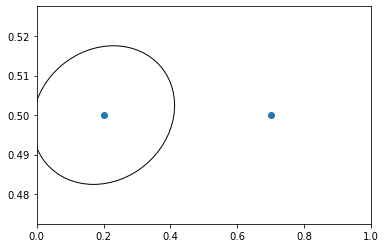

In [9]:
fig, ax = plt.subplots()
xdata, ydata = (0.2, 0.7), (0.5, 0.5)
ax.plot(xdata, ydata, "o")
ax.set_xlim((0, 1))

trans = (fig.dpi_scale_trans +
         transforms.ScaledTranslation(xdata[0], ydata[0], ax.transData))

# plot an ellipse around the point that is 150 x 130 points in diameter...
circle = mpatches.Ellipse((0, 0), 150/72, 130/72, angle=40,
                          fill=None, transform=trans)
ax.add_patch(circle)
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The order of transformation matters.  Here the ellipse
  is given the right dimensions in display space *first* and then moved
  in data space to the correct spot.
  If we had done the ``ScaledTranslation`` first, then
  ``xdata[0]`` and ``ydata[0]`` would
  first be transformed to ``display`` coordinates (``[ 358.4  475.2]`` on
  a 200-dpi monitor) and then those coordinates
  would be scaled by ``fig.dpi_scale_trans`` pushing the center of
  the ellipse well off the screen (i.e. ``[ 71680.  95040.]``).</p></div>


Using offset transforms to create a shadow effect
=================================================

Another use of :class:`~matplotlib.transforms.ScaledTranslation` is to create
a new transformation that is
offset from another transformation, e.g., to place one object shifted a
bit relative to another object.  Typically you want the shift to be in
some physical dimension, like points or inches rather than in data
coordinates, so that the shift effect is constant at different zoom
levels and dpi settings.

One use for an offset is to create a shadow effect, where you draw one
object identical to the first just to the right of it, and just below
it, adjusting the zorder to make sure the shadow is drawn first and
then the object it is shadowing above it.

Here we apply the transforms in the *opposite* order to the use of
:class:`~matplotlib.transforms.ScaledTranslation` above. The plot is
first made in data units (``ax.transData``) and then shifted by
``dx`` and ``dy`` points using `fig.dpi_scale_trans`.  (In typography,
a`point <https://en.wikipedia.org/wiki/Point_%28typography%29>`_ is
1/72 inches, and by specifying your offsets in points, your figure
will look the same regardless of the dpi resolution it is saved in.)



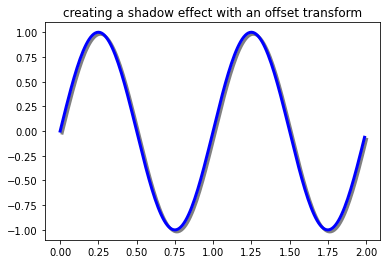

In [10]:
fig, ax = plt.subplots()

# make a simple sine wave
x = np.arange(0., 2., 0.01)
y = np.sin(2*np.pi*x)
line, = ax.plot(x, y, lw=3, color='blue')

# shift the object over 2 points, and down 2 points
dx, dy = 2/72., -2/72.
offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
shadow_transform = ax.transData + offset

# now plot the same data with our offset transform;
# use the zorder to make sure we are below the line
ax.plot(x, y, lw=3, color='gray',
        transform=shadow_transform,
        zorder=0.5*line.get_zorder())

ax.set_title('creating a shadow effect with an offset transform')
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The dpi and inches offset is a
  common-enough use case that we have a special helper function to
  create it in :func:`matplotlib.transforms.offset_copy`, which returns
  a new transform with an added offset. So above we could have done::

     shadow_transform = transforms.offset_copy(ax.transData,
              fig=fig, dx, dy, units='inches')</p></div>



The transformation pipeline
===========================

The ``ax.transData`` transform we have been working with in this
tutorial is a composite of three different transformations that
comprise the transformation pipeline from `data` -> `display`
coordinates.  Michael Droettboom implemented the transformations
framework, taking care to provide a clean API that segregated the
nonlinear projections and scales that happen in polar and logarithmic
plots, from the linear affine transformations that happen when you pan
and zoom.  There is an efficiency here, because you can pan and zoom
in your axes which affects the affine transformation, but you may not
need to compute the potentially expensive nonlinear scales or
projections on simple navigation events.  It is also possible to
multiply affine transformation matrices together, and then apply them
to coordinates in one step.  This is not true of all possible
transformations.


Here is how the ``ax.transData`` instance is defined in the basic
separable axis :class:`~matplotlib.axes.Axes` class::

  self.transData = self.transScale + (self.transLimits + self.transAxes)

We've been introduced to the ``transAxes`` instance above in
`axes-coords`, which maps the (0, 0), (1, 1) corners of the
axes or subplot bounding box to `display` space, so let's look at
these other two pieces.

``self.transLimits`` is the transformation that takes you from
``data`` to ``axes`` coordinates; i.e., it maps your view xlim and ylim
to the unit space of the axes (and ``transAxes`` then takes that unit
space to display space).  We can see this in action here

.. sourcecode:: ipython

    In [80]: ax = subplot(111)

    In [81]: ax.set_xlim(0, 10)
    Out[81]: (0, 10)

    In [82]: ax.set_ylim(-1, 1)
    Out[82]: (-1, 1)

    In [84]: ax.transLimits.transform((0, -1))
    Out[84]: array([ 0.,  0.])

    In [85]: ax.transLimits.transform((10, -1))
    Out[85]: array([ 1.,  0.])

    In [86]: ax.transLimits.transform((10, 1))
    Out[86]: array([ 1.,  1.])

    In [87]: ax.transLimits.transform((5, 0))
    Out[87]: array([ 0.5,  0.5])

and we can use this same inverted transformation to go from the unit
`axes` coordinates back to `data` coordinates.

.. sourcecode:: ipython

    In [90]: inv.transform((0.25, 0.25))
    Out[90]: array([ 2.5, -0.5])

The final piece is the ``self.transScale`` attribute, which is
responsible for the optional non-linear scaling of the data, e.g., for
logarithmic axes.  When an Axes is initially setup, this is just set to
the identity transform, since the basic Matplotlib axes has linear
scale, but when you call a logarithmic scaling function like
:meth:`~matplotlib.axes.Axes.semilogx` or explicitly set the scale to
logarithmic with :meth:`~matplotlib.axes.Axes.set_xscale`, then the
``ax.transScale`` attribute is set to handle the nonlinear projection.
The scales transforms are properties of the respective ``xaxis`` and
``yaxis`` :class:`~matplotlib.axis.Axis` instances.  For example, when
you call ``ax.set_xscale('log')``, the xaxis updates its scale to a
:class:`matplotlib.scale.LogScale` instance.

For non-separable axes the PolarAxes, there is one more piece to
consider, the projection transformation.  The ``transData``
:class:`matplotlib.projections.polar.PolarAxes` is similar to that for
the typical separable matplotlib Axes, with one additional piece
``transProjection``::

      self.transData = self.transScale + self.transProjection + \
          (self.transProjectionAffine + self.transAxes)

``transProjection`` handles the projection from the space,
e.g., latitude and longitude for map data, or radius and theta for polar
data, to a separable Cartesian coordinate system.  There are several
projection examples in the ``matplotlib.projections`` package, and the
best way to learn more is to open the source for those packages and
see how to make your own, since Matplotlib supports extensible axes
and projections.  Michael Droettboom has provided a nice tutorial
example of creating a Hammer projection axes; see
:doc:`/gallery/misc/custom_projection`.

